## ----------------SHOR'S ALGORITHM-------------------

In [96]:
from qiskit.aqua.algorithms import Shor
from qiskit.aqua import QuantumInstance
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

In [97]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots = 1000)
my_shor = Shor(N = 15, a = 2 , quantum_instance = quantum_instance)
Shor.run(my_shor)

/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


{'factors': [[3, 5]], 'total_counts': 61, 'successful_counts': 16}

In [98]:
def c_amod15(a, power):
    U = QuantumCircuit(4)
    for iteration in range(power):
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = "%i^%imod15"%(a, power)
    c_U = U.control()
    return c_U

In [99]:
n_count = 8
a = 7

In [100]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)),m,j)
        qc.h(j)
    qc.name= "QFT dagger"
    return qc

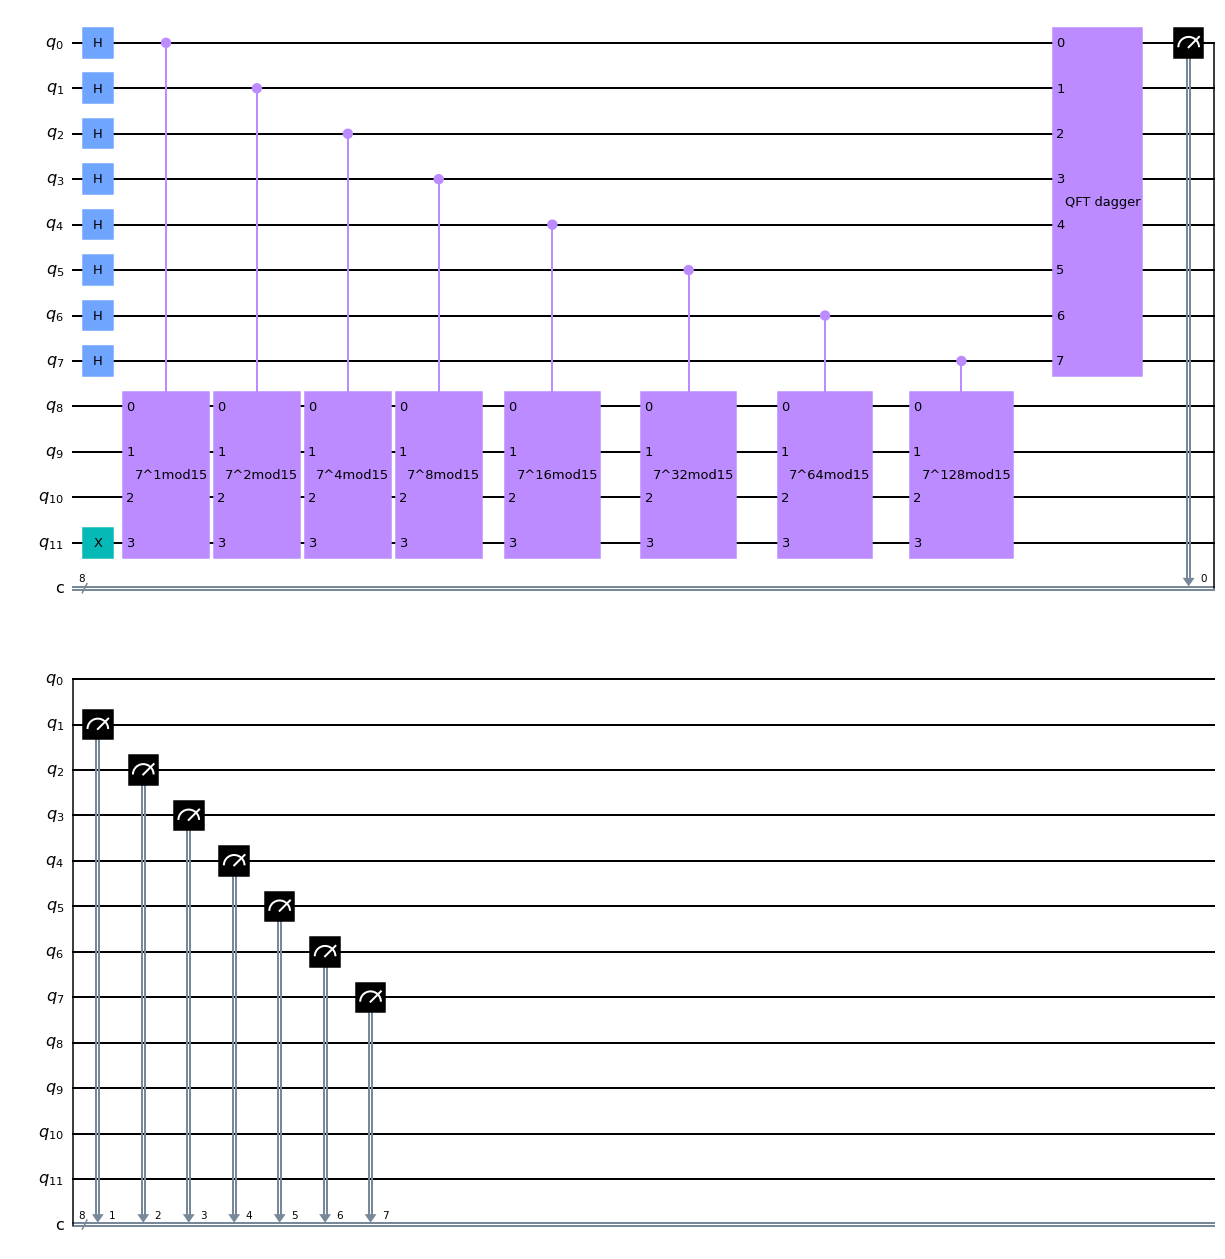

In [101]:
qc = QuantumCircuit(n_count+4, n_count)

for q in range(n_count):
    qc.h(q)
    
qc.x(3+n_count)

for q in range(n_count):
    qc.append(c_amod15(a, 2**q),[q]+[i+n_count for i in range(4)])
    
qc.append(qft_dagger(n_count), range(n_count))
    
qc.measure(range(n_count), range(n_count))
  
qc.draw()

In [107]:
simulator = Aer.get_backend('qasm_simulator')
results = execute(qc, backend=simulator ,shots= 2048).results()
counts = results.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(result.get_counts(qc))

Traceback (most recent call last):
  File "/tmp/ipykernel_94/3777980616.py", line 2, in <module>
    results = execute(qc, backend=simulator ,shots= 2048).results()
AttributeError: 'AerJob' object has no attribute 'results'

Use %tb to get the full traceback.


### ------------------QUANTUM TELEPORTATION---------------

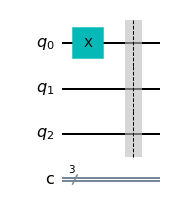

In [108]:

from qiskit import *
circuit = QuantumCircuit(3, 3)
circuit.x(0)
circuit.barrier()
circuit.draw()

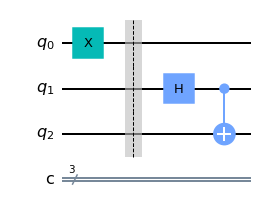

In [109]:
circuit.h(1)
circuit.cx(1, 2)
circuit.draw()

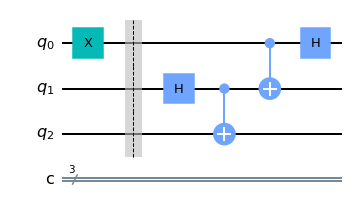

In [110]:
circuit.cx(0 ,1)
circuit.h(0)
circuit.draw()

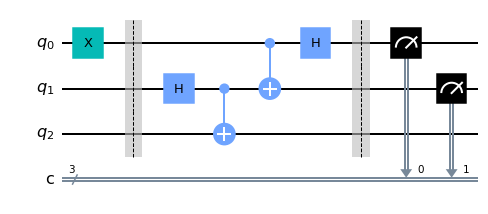

In [111]:
circuit.barrier()
circuit.measure([0,1],[0,1])
circuit.draw()

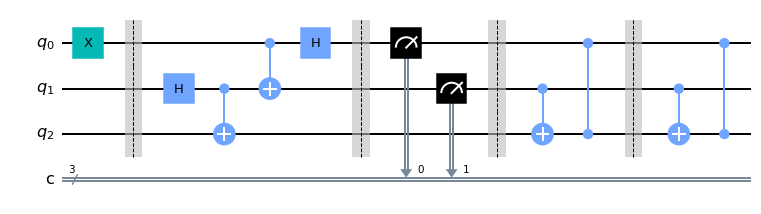

In [113]:
circuit.barrier()
circuit.cx(1,2)
circuit.cz(0,2)
circuit.draw()

In [114]:
circuit.measure(2,2)

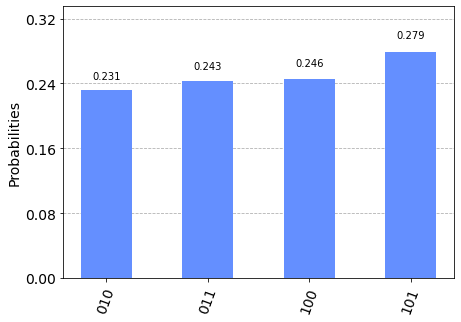

In [115]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

## -----------------SUPERDENSE CODING------------------

In [116]:
from qiskit import *
from qiskit.visualization import plot_histogram

In [117]:
def create_bell_pair():
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1,0)
    return qc

In [118]:
def encode_message(qc,qubit,msg):
    if msg[1]=='1':
        qc.x(qubit)
    if msg[0]=='1':
        qc.z(qubit)
    return qc

In [119]:
def decode_message(qc):
    qc.cx(1,0)
    qc.h(1)
    return qc

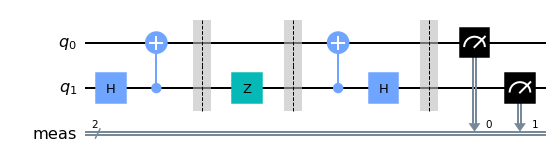

In [120]:
qc = create_bell_pair()
qc.barrier()

message = '10'#you can check this by changing this value
qc = encode_message(qc,1,message)
qc.barrier()

qc = decode_message(qc)
qc.measure_all()
qc.draw()

{'10': 1024}


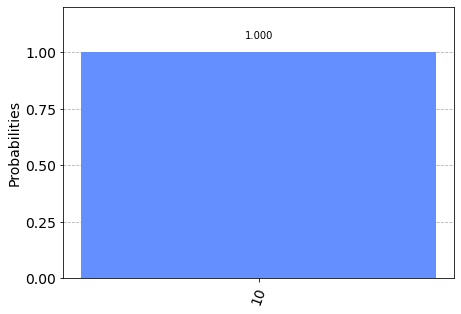

In [121]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

# -----------------NOISE REDUCTION ON ACTUAL QUANTUM COMPUTER ---------------------

In [122]:
from qiskit import *

In [126]:
nqubits = 3
circuit = QuantumCircuit(nqubits,nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.measure([0,1,2],[0,1,2])

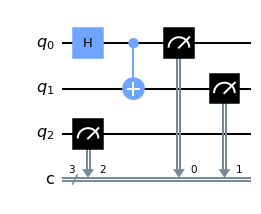

In [127]:
circuit.draw()

In [128]:
simulator =Aer.get_backend('qasm_simulator')
sim_result = execute(circuit,backend=simulator,shots=1024).result()

In [129]:
from qiskit.visualization import plot_histogram

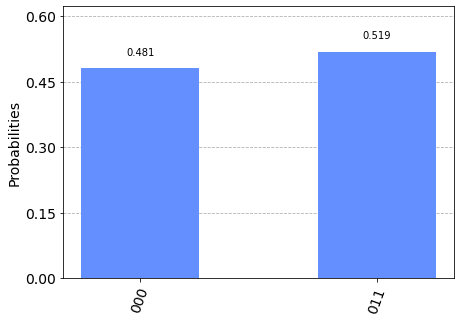

In [130]:
plot_histogram(sim_result.get_counts(circuit))

In [131]:
IBMQ.load_account()
provider=IBMQ.get_provider(hub ='ibm-q')
device = provider.get_backend('ibmq_lima')

ibmqfactory.load_account:WARNING:2021-10-07 13:27:40,393: Credentials are already in use. The existing account in the session will be replaced.


In [132]:
job = execute(circuit, backend=device,shots=1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

615ef5cf565f9499838a17e6
Job Status: job has successfully run


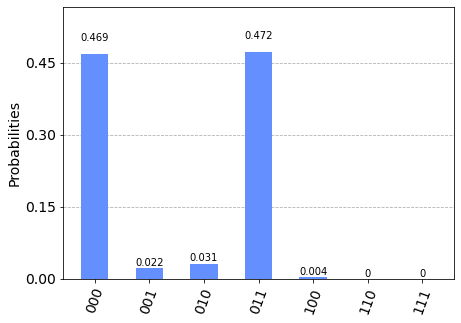

In [133]:
device_result =job.result()
plot_histogram(device_result.get_counts(circuit))

In [134]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [135]:
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], circlabel='measerrormitigationcal')

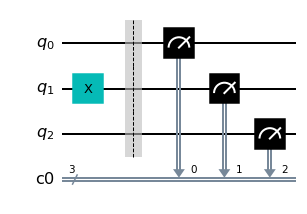

In [136]:
cal_circuits[2].draw()

In [137]:
len(cal_circuits)

8

In [142]:
cal_job= execute(cal_circuits,
                 backend = device,
                 shots =1024,
                 optimization_level = 0
                )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

615ef72199d7733a3aea55e0
Job Status: job has successfully run


Traceback (most recent call last):
  File "/tmp/ipykernel_94/3025198689.py", line 1, in <module>
    plot_histogram(cal_results)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py", line 148, in plot_histogram
    labels = list(sorted(functools.reduce(lambda x, y: x.union(y.keys()), data, set())))
TypeError: reduce() arg 2 must support iteration

Use %tb to get the full traceback.


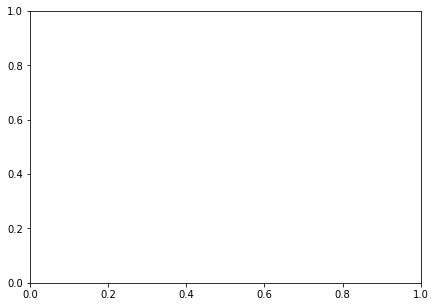

In [148]:
plot_histogram(cal_results.reduce(lamda cal_circuits,y :x.union(y.keys()),data,set()))

In [156]:
meas_filter = CompleteMeasFitter(cal_results, state_labels)

In [157]:
meas_fitter.plot_calibration()

Traceback (most recent call last):
  File "/tmp/ipykernel_94/3142253435.py", line 1, in <module>
    meas_fitter.plot_calibration()
NameError: name 'meas_fitter' is not defined

Use %tb to get the full traceback.


In [78]:
meas_filter = meas_filter.filter

In [79]:
mitigated_result=meas_filter.apply(device_result)

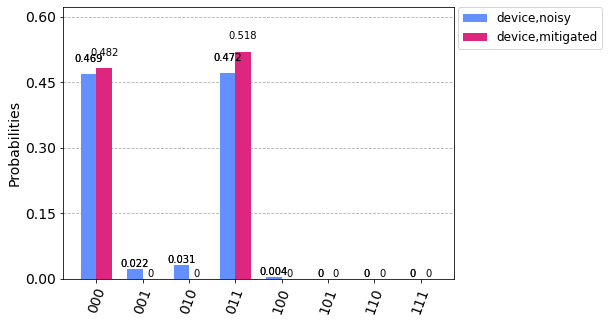

In [161]:
device_counts = device_result.get_counts(circuit)
mitigated_counts=mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device,noisy','device,mitigated'])

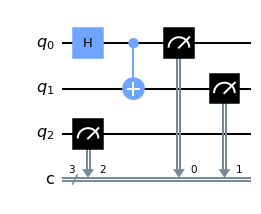

In [165]:
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2],[0,1,2])
circuit.draw()

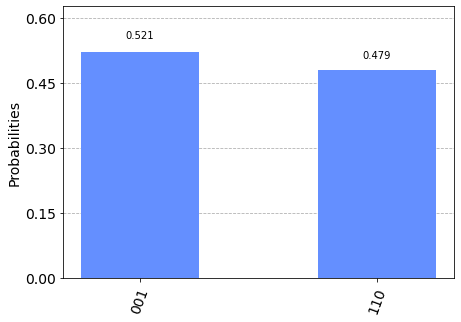

In [167]:
plot_histogram(
    execute(circuit2,backend=simulator,shots=1024).result().get_counts(circuit2) 
)

In [168]:
device_counts_2 = execute(circuit2,backend=device,shots=1024).result().get_counts(circuit2)

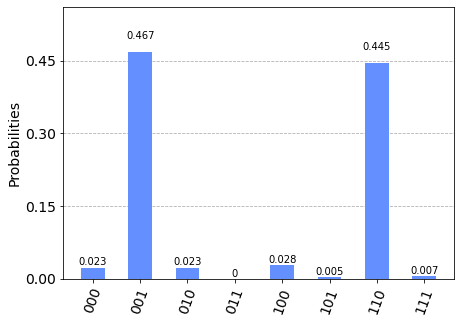

In [169]:
plot_histogram(device_counts_2)

In [176]:
device_mitigated_counts_2 =meas_filter.apply(device_counts_2)

Traceback (most recent call last):
  File "/tmp/ipykernel_94/2108044576.py", line 1, in <module>
    device_mitigated_counts_2 =meas_filter.apply(device_counts_2)
AttributeError: 'CompleteMeasFitter' object has no attribute 'apply'

Use %tb to get the full traceback.


In [173]:
plot_histogram(device_mitigated_counts_2)

Traceback (most recent call last):
  File "/tmp/ipykernel_94/581809623.py", line 1, in <module>
    plot_histogram(device_mitigated_counts_2)
NameError: name 'device_mitigated_counts_2' is not defined

Use %tb to get the full traceback.


## ------------QUANTUM CHEMISTRY APPLICATION--------------

In [186]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [187]:
molecule='H.0.0-{0};Li.0.0{0}'
distances = np.arange(0.5,4.25,0.25)
vqe_energies=[]
hf_energies=[]
exact_energies=[]

In [191]:
for i,d in enumerate(distances):
    print('step',i)
    
    #setup the experiment
    driver = PySCFDriver(molecule.format(d/2),basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(
                  qubit_mapping =QubitMappingType.PARITY,
                  two_qubit_reduction = True, freeze_core =True,
                  orbital_reduction =[-3,-2])
    qubit_op, aux_op = operator.run(qmolecule)
        
    #exact classical result
    exact_result =NumPyMinimumEigensolver(qubit_op,aux_operators=aux_op).run()
    exact_result =operator.process_algoithm_result(exact_result)
        
    #VQE
    optimizer = SLSQP(maxiter=1000)
    initial_state = HartreeeFock(
                      operator.molecule_info['num_orbitals'],
                      operator.molecule_info['num_particles'],
                      qubit_mapping=operatos._qubit_mapping,
                      two_qubit_reduction=operator._two_qubit_resuction)
    var_form=UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                   num_particles=operator.molecule_info['num_particles'],
                   initial_state=initial_state,
                   qubit_mapping=operator._qubit_mapping,
                   two_qubit_reduction=operator._two_qubit_resuction)
    algo=VQE(qubit_op,var_form,optimizer,aux_operators=aux_ops)
    vqe_result=algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result=operator.process_algorithm_result(vqe_result)
        
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)
    

step 0
Traceback (most recent call last):
  File "/tmp/ipykernel_94/3752970308.py", line 6, in <module>
    qmolecule = driver.run()
  File "/opt/conda/lib/python3.8/site-packages/qiskit/chemistry/drivers/pyscfd/pyscfdriver.py", line 135, in run
    q_mol = compute_integrals(atom=atom,
  File "/opt/conda/lib/python3.8/site-packages/qiskit/chemistry/drivers/pyscfd/integrals.py", line 50, in compute_integrals
    atom = _check_molecule_format(atom)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/chemistry/drivers/pyscfd/integrals.py", line 100, in _check_molecule_format
    raise QiskitChemistryError('Failed to convert atom string: ' + val) from exc
QiskitChemistryError: 'Failed to convert atom string: H.0.0-0.25;Li.0.00.25'

Use %tb to get the full traceback.


In [189]:
pylab.plot(distances_hf_energies,label='Hartree-Fock')
pylab.plot(distances,vqe_energies,'o',label ='VQE')
pylab.plot(distances,exact_energies,'x',label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')

Traceback (most recent call last):
  File "/tmp/ipykernel_94/554813608.py", line 1, in <module>
    pylab.plot(distances_hf_energies,label='Hartree-Fock')
NameError: name 'distances_hf_energies' is not defined

Use %tb to get the full traceback.
